http://library.jsce.or.jp/jsce/open/00039/201506_no51/pdf/400.pdf

ここの再現を行う．

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import rich.traceback

In [2]:
rich.traceback.install(show_locals=True)
from pathlib import Path
import os

if (pwd := Path.cwd()).stem == 'test':
    os.chdir(pwd.parent)

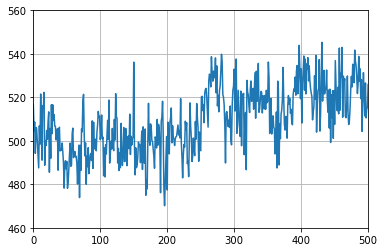

In [3]:
# dataset 1 の作成
def make_dataset_1():
    r"""ARMA モデルにしたがって時系列データ $x_t$ を発生させる．

    $$
    z_t = \alpha z_{t-1} + \epsilon_t + \beta \epsilon_{t-1}
    \\
    x_t = z_t + \mu_t
    $$

    ただし $z_0 = 0, \epsilon_0 = 0$ とした．

    Returns
    -------
    x_t: 長さ 501 の信号
    """
    def get_mu(time):
        if time == 150:
            return 535
        if time > 250:
            return 520
        else:
            return 500

    T = 501
    x = np.zeros(T)
    z_t = 0.0
    eps_t = np.random.normal(0, 10)
    alpha = 0.8
    beta = -0.6

    # if t = 0
    z_t = eps_t
    x[0] = z_t + get_mu(0)
    # otherwise
    for t in range(1, T):
        z_t = alpha * z_t
        z_t += beta * eps_t
        eps_t = np.random.normal(0, 10)
        z_t += eps_t

        x[t] = z_t + get_mu(t)

    return x

data1 = make_dataset_1()

plt.plot(data1)
plt.ylim(460, 560)
plt.xlim(0, 500)
plt.grid()
plt.show()

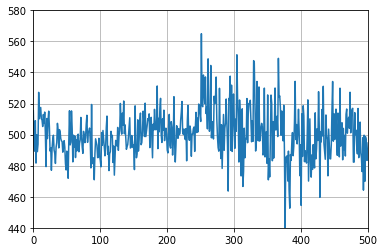

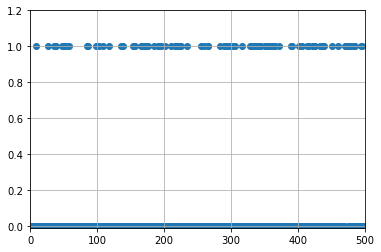

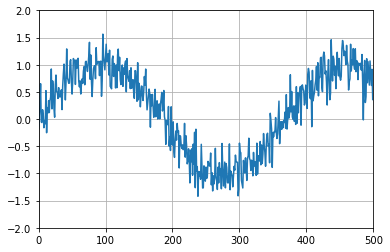

In [4]:
# dataset 2 の作成
def make_dataset_2():
    r"""ARMAX モデルにしたがって時系列データ $x_t$ を発生させる．

    $$
    z_t = \alpha z_{t-1} + \epsilon_t + \beta \epsilon_{t-1}
    \\
    x_t = z_t + \mu + \gamma_1 \xi_{1t} + \gamma_2 \xi_{2t}
    $$

    Returns
    -------
    x: 長さ 501 の信号
    xi_1: 1 つ目の外生変数 (0 or 1)
    xi_2: 2 つ目の外生変数
    """
    def get_sigma(t):
        if t > 250:
            return 20
        else:
            return 10

    T = 501
    x = np.zeros(T)
    mu = 500
    alpha = 0.8
    beta = -0.6
    gamma_1 = 6.0
    gamma_2 = -4.0

    xi_1 = stats.bernoulli.rvs(0.2, size=T)
    xi_2 = np.sin(0.017 * np.arange(T)) + np.random.normal(0, 0.25, size=T)

    # if t = 0
    eps_t = np.random.normal(0, get_sigma(0))
    z_t = eps_t
    x[0] = z_t + mu + gamma_1 * xi_1[0] + gamma_2 * xi_2[0]
    # otherwise
    for t in range(1, T):
        z_t = alpha * z_t
        z_t += beta * eps_t
        eps_t = np.random.normal(0, get_sigma(t))
        z_t += eps_t

        x[t] = z_t + mu + gamma_1 * xi_1[t] + gamma_2 * xi_2[t]

    return x, xi_1, xi_2

data2, xi1, xi2 = make_dataset_2()
plt.plot(data2)
plt.xlim(0, 500)
plt.ylim(440, 580)
plt.grid()
plt.show()
plt.scatter(np.arange(len(xi1)), xi1)
plt.xlim(0, 500)
plt.ylim(-0.01, 1.2)
plt.grid()
plt.show()
plt.plot(xi2)
plt.xlim(0, 500)
plt.ylim(-2, 2)
plt.grid()
plt.show()

SMC を用いた ARMAX のパラメタ推定

In [5]:
class TransitionModel(object):
    """パーティクル移動のモデル
    """
    def __init__(self):
        pass

    def predict(self, current):
        """平均 0, 分散 2 の範囲で移動するモデル

        Parameters
        ----------
        current : np.ndarray

        Returns
        -------
        np.ndarray
        """
        shape = current.shape
        return current + np.random.randn(shape[0], shape[1]) * 2

class ObservationModel(object):
    """観測モデル
    """
    def __init__(self):
        pass

    def likelihood(self, prediction, observation, sigma):
        """予測の尤もらしさ

        $$
        \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(x_t-w_t)^2}{2\sigma^2}\right]
        $$

        Parameters
        ----------
        prediction : np.ndarray
        observation : np.ndarray
        sigma : np.ndarray

        Returns
        -------
        上の式での計算結果を返す
        """
        return np.exp(- (prediction - observation)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)

C:\Users\siitake\miniconda3\envs\dev_changefinder\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
